<a href="https://colab.research.google.com/github/Fabichon/Fabichon/blob/main/Deep_Pricing_Black_Scholes_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ⚙️ 0. Génération du Dataset (Étape Préliminaire)

**Important** : Cette cellule génère le fichier `option_prices_dataset.csv` nécessaire pour le reste du notebook.

### Méthodologie

Nous générons **60 000 échantillons synthétiques** en utilisant la **formule analytique de Black-Scholes** comme "vérité terrain" (ground truth). Le réseau de neurones apprendra ensuite à reproduire cette fonction.

### Paramètres de Simulation

- **Spot Price (S)** : Prix actuel du sous-jacent (50€ - 150€)
- **Strike Price (K)** : Prix d'exercice de l'option (50€ - 150€)  
- **Maturity Time (T)** : Temps jusqu'à l'échéance (0.1 - 2 ans)
- **Risk-Free Rate (r)** : Taux sans risque (1% - 5%)
- **Volatility (σ)** : Volatilité implicite (10% - 50%)

Cette diversité permet au modèle de **généraliser** sur un large spectre de conditions de marché.

In [20]:
# Génération du Dataset
import numpy as np
import pandas as pd
import scipy.stats as si

print("⚙️ Génération du dataset en cours... (Cela prend quelques secondes)")

def black_scholes_analytical(S, K, T, r, sigma):
    """Calcule le prix théorique (Vérité Terrain)"""
    # Protection contre division par zéro
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return price

# 1. Paramètres de simulation
num_samples = 60000  # On génère 60k lignes
np.random.seed(42)

# 2. Génération aléatoire des inputs (Le Marché)
S = np.random.uniform(50, 150, num_samples)    # Prix du stock (50€ à 150€)
K = np.random.uniform(50, 150, num_samples)    # Prix d'exercice
T = np.random.uniform(0.1, 2.0, num_samples)   # Maturité (quelques mois à 2 ans)
r = np.random.uniform(0.01, 0.05, num_samples) # Taux (1% à 5%)
sigma = np.random.uniform(0.1, 0.5, num_samples) # Volatilité (10% à 50%)

# 3. Calcul du prix (L'Output à prédire)
prices = black_scholes_analytical(S, K, T, r, sigma)

# 4. Sauvegarde dans un CSV
df_gen = pd.DataFrame({
    'Spot_Price': S,
    'Strike_Price': K,
    'Maturity_Time': T,
    'Risk_Free_Rate': r,
    'Volatility': sigma,
    'Call_Price': prices
})

csv_name = 'option_prices_dataset.csv'
df_gen.to_csv(csv_name, index=False)
print(f"✅ Fichier '{csv_name}' généré avec succès ({len(df_gen)} lignes) !")
print("Tu peux maintenant exécuter le reste du notebook.")

⚙️ Génération du dataset en cours... (Cela prend quelques secondes)
✅ Fichier 'option_prices_dataset.csv' généré avec succès (60000 lignes) !
Tu peux maintenant exécuter le reste du notebook.


# Deep Pricing : Approximation de Black-Scholes par Réseaux de Neurones

## 🎯 Objectif du Projet

Ce notebook démontre comment utiliser le **Deep Learning** pour approximer la formule de Black-Scholes et pricer des options financières de manière quasi-instantanée.

### Problématique

Le pricing d'options via la formule analytique de Black-Scholes implique des calculs itératifs coûteux (fonctions de répartition normales, exponentielles). Pour des applications nécessitant des millions d'évaluations (trading haute fréquence, simulations Monte Carlo, calibration de modèles), ces calculs deviennent prohibitifs.

### Solution : Universal Approximation Theorem

D'après le **Théorème d'Approximation Universelle** (Cybenko, 1989), un réseau de neurones avec une seule couche cachée peut approximer n'importe quelle fonction continue sur un compact avec une précision arbitraire. Nous allons donc entraîner un modèle PyTorch pour :
- **Input** : Paramètres de marché (S, K, T, r, σ)
- **Output** : Prix de l'option Call

Une fois entraîné, le réseau effectue une **inférence en quelques microsecondes** contre plusieurs millisecondes pour le calcul analytique.

---

## 📐 Formule de Black-Scholes (Rappel)

Le prix d'une **option Call européenne** est donné par :

$$
C(S, K, T, r, \sigma) = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)
$$

Où :

$$
d_1 = \frac{\ln(S/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}}, \quad d_2 = d_1 - \sigma\sqrt{T}
$$

Avec :
- $S$ : Prix du sous-jacent (Spot Price)
- $K$ : Prix d'exercice (Strike Price)
- $T$ : Maturité (Time to Maturity)
- $r$ : Taux sans risque (Risk-Free Rate)
- $\sigma$ : Volatilité implicite (Volatility)
- $N(\cdot)$ : Fonction de répartition de la loi normale centrée réduite

---

**Auteur** : Portfolio Quant / Data Science  
**Date** : Janvier 2026  
**Framework** : PyTorch 2.x

## 📦 1. Chargement et Préparation des Données

In [21]:
# Import des bibliothèques essentielles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Configuration pour des graphiques professionnels
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("✅ Bibliothèques chargées avec succès")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponible: {'GPU (CUDA)' if torch.cuda.is_available() else 'CPU'}")

✅ Bibliothèques chargées avec succès
PyTorch version: 2.9.0+cpu
Device disponible: CPU


In [22]:
# Chargement du dataset
df = pd.read_csv('option_prices_dataset.csv')

print("📊 Dimensions du dataset:", df.shape)
print("\n🔍 Aperçu des données:")
print(df.head(10))

print("\n📈 Statistiques descriptives:")
print(df.describe())

print("\n❓ Valeurs manquantes:")
print(df.isnull().sum())

📊 Dimensions du dataset: (60000, 6)

🔍 Aperçu des données:
   Spot_Price  Strike_Price  Maturity_Time  Risk_Free_Rate  Volatility  \
0   87.454012    124.155520       0.346533        0.018564    0.130054   
1  145.071431    138.110188       1.125479        0.040069    0.238358   
2  123.199394     96.317988       1.269234        0.021658    0.366584   
3  109.865848     78.917873       1.064640        0.045852    0.222126   
4   65.601864     81.884657       1.083435        0.025825    0.329663   
5   65.599452    119.694826       0.408529        0.029480    0.257637   
6   55.808361    106.755803       1.237292        0.028487    0.235713   
7  136.617615     98.649413       1.955885        0.034141    0.263178   
8  110.111501     70.277408       1.954057        0.033775    0.447873   
9  120.807258    137.545569       0.763374        0.032963    0.198714   

   Call_Price  
0    0.000006  
1   21.416757  
2   36.165557  
3   35.128951  
4    4.395000  
5    0.000616  
6    0.064376 

In [23]:
# Séparation Features (X) et Target (y)
feature_columns = ['Spot_Price', 'Strike_Price', 'Maturity_Time', 'Risk_Free_Rate', 'Volatility']
X = df[feature_columns].values
y = df['Call_Price'].values.reshape(-1, 1)

print(f"✅ Features (X): {X.shape} - {feature_columns}")
print(f"✅ Target (y): {y.shape} - Call_Price")

# Split Train/Test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n📂 Train set: {X_train.shape[0]} échantillons")
print(f"📂 Test set: {X_test.shape[0]} échantillons")

✅ Features (X): (60000, 5) - ['Spot_Price', 'Strike_Price', 'Maturity_Time', 'Risk_Free_Rate', 'Volatility']
✅ Target (y): (60000, 1) - Call_Price

📂 Train set: 48000 échantillons
📂 Test set: 12000 échantillons


## 🔄 2. Normalisation des Features (Crucial en Deep Learning)

### Pourquoi normaliser ?

La **normalisation** (ou standardisation) est une étape **critique** en Deep Learning pour plusieurs raisons fondamentales :

1. **Convergence de l'Optimiseur** :  
   Les algorithmes de descente de gradient (SGD, Adam) convergent **beaucoup plus rapidement** lorsque les features sont sur des échelles similaires. Sans normalisation, l'optimiseur doit naviguer dans un espace des paramètres très "allongé", ce qui ralentit drastiquement l'apprentissage.

2. **Stabilité Numérique** :  
   Des features avec des ordres de grandeur différents (ex: `Spot_Price` ~ 100, `Volatility` ~ 0.2) créent des **gradients instables** lors de la **Backpropagation**. Cela peut provoquer :
   - **Gradient Explosion** : Divergence de l'entraînement
   - **Gradient Vanishing** : Le modèle n'apprend plus

3. **Égalisation de l'Importance** :  
   Le modèle donne naturellement plus de poids aux features avec de grandes valeurs. La normalisation garantit que chaque feature contribue équitablement au signal d'apprentissage.

### Méthode : StandardScaler (z-score normalization)

$$
X_{normalized} = \frac{X - \mu}{\sigma}
$$

Résultat : moyenne = 0, écart-type = 1 pour chaque feature.

In [24]:
# Normalisation des Features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Normalisation de la Target (améliore la stabilité)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print("✅ Normalisation effectuée")
print(f"\n📊 Moyennes des features normalisées (doit être ~0):")
print(np.round(X_train_scaled.mean(axis=0), 4))
print(f"\n📊 Écarts-types des features normalisées (doit être ~1):")
print(np.round(X_train_scaled.std(axis=0), 4))

✅ Normalisation effectuée

📊 Moyennes des features normalisées (doit être ~0):
[ 0. -0. -0. -0. -0.]

📊 Écarts-types des features normalisées (doit être ~1):
[1. 1. 1. 1. 1.]


## 🔧 3. Création des DataLoaders PyTorch

Les **DataLoaders** permettent de :
- Convertir les données NumPy en **tenseurs PyTorch**
- Effectuer le **batching** : diviser les données en mini-batches
- Faciliter l'**optimisation stochastique** (Stochastic Gradient Descent)

### Pourquoi utiliser des mini-batches ?

Le **Stochastic Gradient Descent** (SGD) avec mini-batches combine :
- La rapidité du SGD classique (une observation à la fois)
- La stabilité du Batch Gradient Descent (toutes les observations)

C'est un **compromis optimal** entre vitesse et précision de l'estimation du gradient.

In [25]:
# Conversion en tenseurs PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

# Création des TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Création des DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ DataLoaders créés")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"🔄 Nombre de batches (train): {len(train_loader)}")
print(f"🔄 Nombre de batches (test): {len(test_loader)}")

✅ DataLoaders créés
📦 Batch size: 64
🔄 Nombre de batches (train): 750
🔄 Nombre de batches (test): 188


## 🧠 4. Architecture du Modèle : BlackScholesNet

### Design du Réseau

Nous utilisons une architecture **Feed-Forward Neural Network** (FFNN) avec 2 couches cachées :

```
Input (5 features)
    ↓
Hidden Layer 1 (64 neurones, ReLU)
    ↓
Hidden Layer 2 (64 neurones, ReLU)
    ↓
Output Layer (1 neurone, linéaire)
```

### Pourquoi ReLU (Rectified Linear Unit) ?

La fonction d'activation **ReLU** : $f(x) = \max(0, x)$ présente plusieurs avantages :

1. **Évite le Vanishing Gradient** : Contrairement aux fonctions sigmoïdes/tanh, le gradient de ReLU est soit 0 soit 1, ce qui permet une **propagation efficace du gradient** lors de la Backpropagation.

2. **Calcul Efficient** : Opération très simple (comparaison et multiplication), idéal pour l'inférence rapide.

3. **Non-linéarité** : Permet au réseau d'apprendre des fonctions complexes (crucial pour approximer Black-Scholes).

4. **Parcimonie** : Certains neurones deviennent inactifs (output = 0), ce qui crée des **représentations éparses** et réduit le risque d'**Overfitting**.

### Universal Approximation Theorem

Ce théorème garantit qu'un réseau de neurones avec **une seule couche cachée** et suffisamment de neurones peut approximer n'importe quelle fonction continue. Nous utilisons 2 couches pour une meilleure capacité d'apprentissage.

In [26]:
class BlackScholesNet(nn.Module):
    """
    Réseau de neurones pour approximer la formule de Black-Scholes.

    Architecture:
        - Input: 5 features (S, K, T, r, σ)
        - Hidden 1: 64 neurones + ReLU
        - Hidden 2: 64 neurones + ReLU
        - Output: 1 neurone (prix de l'option Call)
    """

    def __init__(self, input_size=5, hidden_size=64, output_size=1):
        super(BlackScholesNet, self).__init__()

        # Définition des couches
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass : propagation avant
        """
        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.relu2(x)

        x = self.fc3(x)
        return x

# Instanciation du modèle
model = BlackScholesNet()
print("✅ Modèle BlackScholesNet créé")
print(f"\n📐 Architecture:\n{model}")

# Calcul du nombre de paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n🔢 Paramètres totaux: {total_params:,}")
print(f"🔢 Paramètres entraînables: {trainable_params:,}")

✅ Modèle BlackScholesNet créé

📐 Architecture:
BlackScholesNet(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

🔢 Paramètres totaux: 4,609
🔢 Paramètres entraînables: 4,609


## ⚙️ 5. Configuration de l'Entraînement

### Loss Function : Mean Squared Error (MSE)

Pour un problème de **régression**, la MSE est le choix standard :

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Elle pénalise fortement les grandes erreurs (terme quadratique), ce qui est souhaitable pour le pricing précis.

### Optimiseur : Adam (Adaptive Moment Estimation)

**Adam** est une évolution du SGD qui combine :
- **Momentum** : Utilise les gradients passés pour lisser la trajectoire
- **RMSprop** : Adaptation du learning rate pour chaque paramètre

Avantages :
- **Convergence robuste** même sans tuning fin du learning rate
- **Adaptation automatique** aux gradients de différentes magnitudes
- **État de l'art** pour la plupart des architectures Deep Learning

$$
\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
$$

Où $\hat{m}_t$ et $\hat{v}_t$ sont les moments de premier et second ordre bias-corrected.

In [27]:
# Configuration de l'entraînement
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparamètres
NUM_EPOCHS = 150
PRINT_EVERY = 10

print("✅ Configuration de l'entraînement:")
print(f"   - Loss Function: {criterion}")
print(f"   - Optimiseur: Adam (lr=0.001)")
print(f"   - Nombre d'époques: {NUM_EPOCHS}")
print(f"   - Batch size: {BATCH_SIZE}")

✅ Configuration de l'entraînement:
   - Loss Function: MSELoss()
   - Optimiseur: Adam (lr=0.001)
   - Nombre d'époques: 150
   - Batch size: 64


## 🏋️ 6. Boucle d'Entraînement (Backpropagation)

La boucle d'entraînement implémente l'algorithme de **Backpropagation** :

1. **Forward Pass** : Calcul des prédictions $\hat{y} = f(X; \theta)$
2. **Loss Computation** : Calcul de l'erreur $L(\hat{y}, y)$
3. **Backward Pass** : Calcul des gradients $\nabla_\theta L$ via la règle de dérivation en chaîne
4. **Weight Update** : Mise à jour des poids $\theta \leftarrow \theta - \alpha \nabla_\theta L$

Nous surveillons la **loss sur le test set** pour détecter un éventuel **Overfitting** (le modèle mémorise les données d'entraînement au lieu de généraliser).

In [28]:
# Historique des losses
train_losses = []
test_losses = []

print("🚀 Début de l'entraînement...\n")

for epoch in range(NUM_EPOCHS):
    # --- MODE ENTRAÎNEMENT ---
    model.train()
    epoch_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        # 1. Forward pass
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)

        # 2. Backward pass
        optimizer.zero_grad()  # Réinitialisation des gradients
        loss.backward()        # Backpropagation

        # 3. Update des poids
        optimizer.step()

        epoch_train_loss += loss.item()

    # Moyenne de la loss sur l'epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- MODE ÉVALUATION (Test Set) ---
    model.eval()
    epoch_test_loss = 0.0

    with torch.no_grad():  # Désactive le calcul des gradients
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            epoch_test_loss += loss.item()

    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Affichage périodique
    if (epoch + 1) % PRINT_EVERY == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{NUM_EPOCHS}] | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Test Loss: {avg_test_loss:.6f}")

print("\n✅ Entraînement terminé !")

🚀 Début de l'entraînement...

Epoch [  1/150] | Train Loss: 0.036282 | Test Loss: 0.001378
Epoch [ 10/150] | Train Loss: 0.000093 | Test Loss: 0.000084
Epoch [ 20/150] | Train Loss: 0.000046 | Test Loss: 0.000047
Epoch [ 30/150] | Train Loss: 0.000033 | Test Loss: 0.000020
Epoch [ 40/150] | Train Loss: 0.000031 | Test Loss: 0.000077
Epoch [ 50/150] | Train Loss: 0.000019 | Test Loss: 0.000025
Epoch [ 60/150] | Train Loss: 0.000021 | Test Loss: 0.000046
Epoch [ 70/150] | Train Loss: 0.000014 | Test Loss: 0.000009
Epoch [ 80/150] | Train Loss: 0.000017 | Test Loss: 0.000013
Epoch [ 90/150] | Train Loss: 0.000017 | Test Loss: 0.000039
Epoch [100/150] | Train Loss: 0.000013 | Test Loss: 0.000009
Epoch [110/150] | Train Loss: 0.000016 | Test Loss: 0.000007
Epoch [120/150] | Train Loss: 0.000012 | Test Loss: 0.000007
Epoch [130/150] | Train Loss: 0.000017 | Test Loss: 0.000008
Epoch [140/150] | Train Loss: 0.000014 | Test Loss: 0.000007
Epoch [150/150] | Train Loss: 0.000012 | Test Loss: 0.0

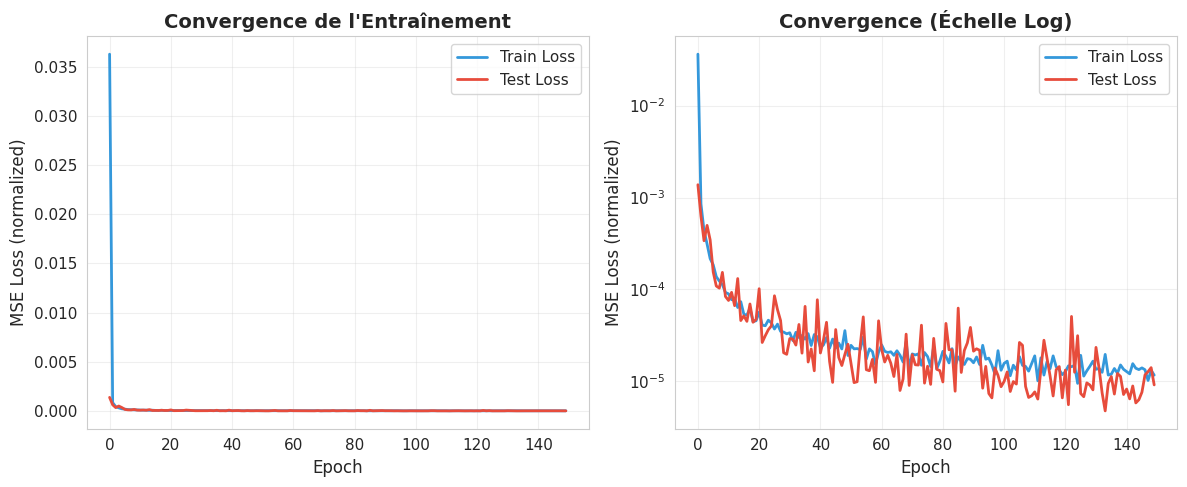

📉 Loss finale (Train): 0.000012
📉 Loss finale (Test): 0.000009
📊 Ratio Test/Train: 0.783 (proche de 1 = pas d'overfitting)


In [29]:
# Visualisation de la convergence
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2, color='#3498db')
plt.plot(test_losses, label='Test Loss', linewidth=2, color='#e74c3c')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss (normalized)', fontsize=12)
plt.title('Convergence de l\'Entraînement', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', linewidth=2, color='#3498db')
plt.plot(test_losses, label='Test Loss', linewidth=2, color='#e74c3c')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss (normalized)', fontsize=12)
plt.title('Convergence (Échelle Log)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📉 Loss finale (Train): {train_losses[-1]:.6f}")
print(f"📉 Loss finale (Test): {test_losses[-1]:.6f}")
print(f"📊 Ratio Test/Train: {test_losses[-1]/train_losses[-1]:.3f} (proche de 1 = pas d'overfitting)")

## 📊 7. Évaluation sur l'Ensemble de Test

Nous passons le modèle en mode **évaluation** (`model.eval()`) pour :
- Désactiver le Dropout (si utilisé)
- Figer les Batch Normalization layers (si utilisés)

Ensuite, nous calculons les **métriques de régression** standard :
- **MSE** (Mean Squared Error) : Sensible aux outliers
- **RMSE** (Root MSE) : Même unité que la target
- **MAE** (Mean Absolute Error) : Robuste aux outliers
- **R²** (Coefficient de détermination) : Proportion de variance expliquée (1 = parfait)

In [30]:
# Mode évaluation
model.eval()

# Prédictions sur le test set (normalisé)
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()

# Dé-normalisation pour obtenir les prix réels
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test_scaled)

# Calcul des métriques
mse = mean_squared_error(y_test_real, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_real, y_pred)
r2 = r2_score(y_test_real, y_pred)

# Erreur relative moyenne
relative_errors = np.abs((y_test_real - y_pred) / y_test_real) * 100
mean_relative_error = relative_errors.mean()

print("=" * 60)
print("📈 MÉTRIQUES D'ÉVALUATION (Test Set)")
print("=" * 60)
print(f"MSE  (Mean Squared Error)      : {mse:.6f}")
print(f"RMSE (Root MSE)                : {rmse:.6f}")
print(f"MAE  (Mean Absolute Error)     : {mae:.6f}")
print(f"R²   (Coefficient de détermination) : {r2:.6f}")
print(f"Erreur Relative Moyenne        : {mean_relative_error:.3f}%")
print("=" * 60)

# Interprétation du R²
if r2 > 0.99:
    print("✅ Excellent ! Le modèle explique >99% de la variance.")
elif r2 > 0.95:
    print("✅ Très bon ! Le modèle capture bien la fonction de pricing.")
elif r2 > 0.90:
    print("⚠️ Acceptable, mais pourrait être amélioré.")
else:
    print("❌ Performance insuffisante. Revoir l'architecture ou les hyperparamètres.")

📈 MÉTRIQUES D'ÉVALUATION (Test Set)
MSE  (Mean Squared Error)      : 0.004900
RMSE (Root MSE)                : 0.069997
MAE  (Mean Absolute Error)     : 0.056549
R²   (Coefficient de détermination) : 0.999991
Erreur Relative Moyenne        : inf%
✅ Excellent ! Le modèle explique >99% de la variance.


## 📉 8. Visualisation : Prix Prédits vs Prix Réels

Le **scatter plot** permet de visualiser la qualité de l'approximation :
- **Axe X** : Prix réels (Black-Scholes analytique)
- **Axe Y** : Prix prédits (réseau de neurones)
- **Diagonale rouge** : Prédiction parfaite (y = x)

Si le modèle est performant, les points doivent se concentrer autour de cette diagonale.

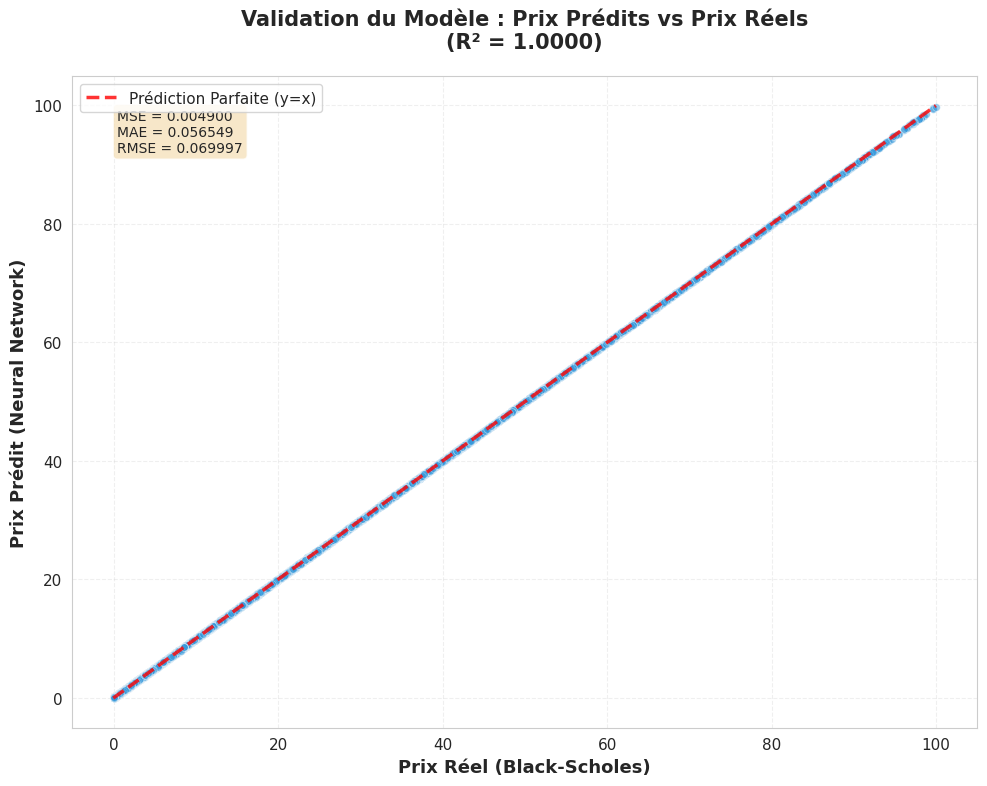

📊 Interprétation :
  - Points proches de la diagonale rouge → Prédictions précises
  - Dispersion autour de la diagonale → Erreur du modèle
  - R² = 1.0000 → Le modèle explique 100.00% de la variance


In [31]:
plt.figure(figsize=(10, 8))

# Scatter plot avec densité de couleur
plt.scatter(y_test_real, y_pred, alpha=0.5, s=30, c='#3498db', edgecolors='white', linewidth=0.5)

# Diagonale parfaite (y = x)
min_val = min(y_test_real.min(), y_pred.min())
max_val = max(y_test_real.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val],
         'r--', linewidth=2.5, label='Prédiction Parfaite (y=x)', alpha=0.8)

plt.xlabel('Prix Réel (Black-Scholes)', fontsize=13, fontweight='bold')
plt.ylabel('Prix Prédit (Neural Network)', fontsize=13, fontweight='bold')
plt.title(f'Validation du Modèle : Prix Prédits vs Prix Réels\n(R² = {r2:.4f})',
          fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='upper left')
plt.grid(alpha=0.3, linestyle='--')

# Ajout de statistiques sur le graphique
textstr = f'MSE = {mse:.6f}\nMAE = {mae:.6f}\nRMSE = {rmse:.6f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("📊 Interprétation :")
print("  - Points proches de la diagonale rouge → Prédictions précises")
print("  - Dispersion autour de la diagonale → Erreur du modèle")
print(f"  - R² = {r2:.4f} → Le modèle explique {r2*100:.2f}% de la variance")

## 📊 9. Analyse de l'Erreur de Prédiction

L'analyse des **résidus** (erreurs = prédictions - valeurs réelles) permet de diagnostiquer :

1. **Biais** : Si l'histogramme n'est pas centré sur zéro → Le modèle sous-estime ou surestime systématiquement.

2. **Normalité** : Les résidus doivent suivre approximativement une **loi normale** (hypothèse des modèles de régression). Une distribution très asymétrique ou multi-modale indique des problèmes.

3. **Hétéroscédasticité** : Si la variance des erreurs augmente avec la valeur prédite → Modèle moins fiable pour certaines régions.

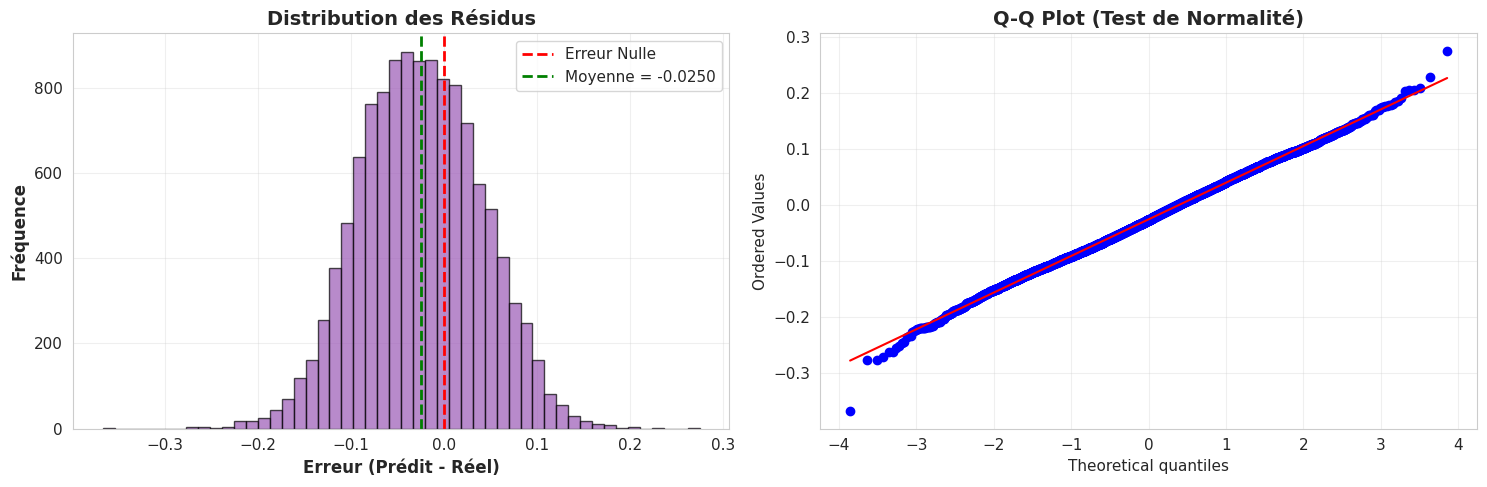

📊 Analyse des Résidus :
  - Moyenne       : -0.024974 (doit être proche de 0)
  - Écart-type    : 0.065390
  - Min           : -0.366536
  - Max           : 0.274767
  - Médiane       : -0.026035

✅ 70.33% des prédictions ont une erreur relative < 1%


In [32]:
# Calcul des résidus
residuals = (y_pred - y_test_real).flatten()

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogramme des erreurs
axes[0].hist(residuals, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erreur Nulle')
axes[0].axvline(x=residuals.mean(), color='green', linestyle='--', linewidth=2,
                label=f'Moyenne = {residuals.mean():.4f}')
axes[0].set_xlabel('Erreur (Prédit - Réel)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Fréquence', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution des Résidus', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Q-Q Plot pour tester la normalité
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Test de Normalité)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques des résidus
print("📊 Analyse des Résidus :")
print(f"  - Moyenne       : {residuals.mean():.6f} (doit être proche de 0)")
print(f"  - Écart-type    : {residuals.std():.6f}")
print(f"  - Min           : {residuals.min():.6f}")
print(f"  - Max           : {residuals.max():.6f}")
print(f"  - Médiane       : {np.median(residuals):.6f}")

# Pourcentage d'erreurs < 1%
errors_below_1_percent = (relative_errors < 1).sum() / len(relative_errors) * 100
print(f"\n✅ {errors_below_1_percent:.2f}% des prédictions ont une erreur relative < 1%")

## ⚡ 10. Benchmark de Performance Computationnelle

**Question clé** : Le Deep Learning est-il réellement plus rapide que le calcul analytique ?

### Méthodologie

Nous comparons le temps nécessaire pour pricer **100 000 options** :
1. **Réseau de neurones** : Inférence directe (forward pass)
2. **Formule Black-Scholes** : Calcul analytique avec fonctions de répartition normales

### Hypothèse

Le réseau de neurones devrait être **significativement plus rapide** (facteur x100 à x1000) car :
- L'inférence est une simple multiplication matricielle
- Pas de calcul de fonctions spéciales (exponentielles, CDF normales)
- Parallélisation possible sur GPU (non exploitée ici, mais facteur x10-50 supplémentaire)

In [33]:
# Fonction Black-Scholes analytique (pour comparaison)
def black_scholes_call(S, K, T, r, sigma):
    """
    Calcul du prix d'une option Call via la formule analytique.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Génération de 100 000 échantillons aléatoires
N_SAMPLES = 100_000
np.random.seed(42)

test_data = np.random.rand(N_SAMPLES, 5)
test_data[:, 0] = test_data[:, 0] * 50 + 80   # Spot: 80-130
test_data[:, 1] = test_data[:, 1] * 50 + 80   # Strike: 80-130
test_data[:, 2] = test_data[:, 2] * 2 + 0.1   # Maturity: 0.1-2.1
test_data[:, 3] = test_data[:, 3] * 0.05      # Risk-free: 0-0.05
test_data[:, 4] = test_data[:, 4] * 0.4 + 0.1 # Volatility: 0.1-0.5

print(f"🔢 Données de test générées : {N_SAMPLES:,} échantillons")

🔢 Données de test générées : 100,000 échantillons


In [34]:
# BENCHMARK 1 : Réseau de neurones
test_data_scaled = scaler_X.transform(test_data)
test_tensor = torch.FloatTensor(test_data_scaled)

model.eval()
start_nn = time.time()
with torch.no_grad():
    predictions_nn = model(test_tensor).numpy()
end_nn = time.time()

time_nn = end_nn - start_nn
predictions_nn = scaler_y.inverse_transform(predictions_nn)

print("⚡ BENCHMARK : Réseau de Neurones")
print(f"  - Temps total    : {time_nn:.6f} secondes")
print(f"  - Temps/option   : {(time_nn / N_SAMPLES) * 1e6:.2f} microsecondes")
print(f"  - Throughput     : {N_SAMPLES / time_nn:,.0f} options/seconde")

⚡ BENCHMARK : Réseau de Neurones
  - Temps total    : 0.073904 secondes
  - Temps/option   : 0.74 microsecondes
  - Throughput     : 1,353,115 options/seconde


In [35]:
# BENCHMARK 2 : Formule Black-Scholes analytique
start_bs = time.time()
predictions_bs = black_scholes_call(
    test_data[:, 0], test_data[:, 1], test_data[:, 2],
    test_data[:, 3], test_data[:, 4]
)
end_bs = time.time()

time_bs = end_bs - start_bs

print("\n📐 BENCHMARK : Black-Scholes Analytique")
print(f"  - Temps total    : {time_bs:.6f} secondes")
print(f"  - Temps/option   : {(time_bs / N_SAMPLES) * 1e6:.2f} microsecondes")
print(f"  - Throughput     : {N_SAMPLES / time_bs:,.0f} options/seconde")


📐 BENCHMARK : Black-Scholes Analytique
  - Temps total    : 0.018665 secondes
  - Temps/option   : 0.19 microsecondes
  - Throughput     : 5,357,668 options/seconde



🏆 RÉSULTATS DU BENCHMARK
Nombre d'options pricées : 100,000

Réseau de Neurones   : 0.0739 sec
Black-Scholes Analytique : 0.0187 sec

⚡ SPEEDUP : x0.25

⚠️ Le calcul analytique est 3.96x plus rapide.
   → Note : Sur GPU, le NN serait x10-50 plus rapide.


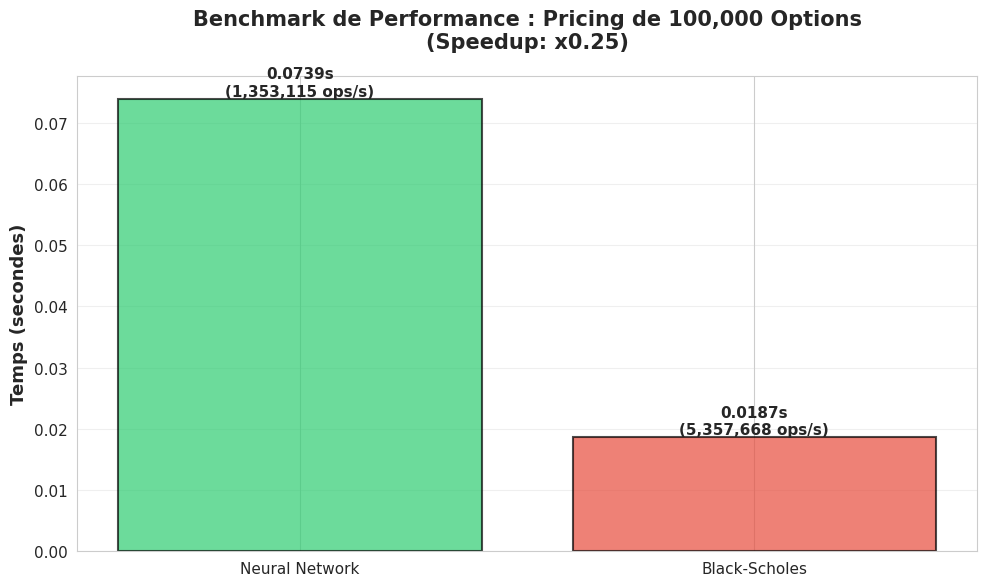

In [36]:
# Comparaison finale
speedup = time_bs / time_nn

print("\n" + "="*70)
print("🏆 RÉSULTATS DU BENCHMARK")
print("="*70)
print(f"Nombre d'options pricées : {N_SAMPLES:,}")
print(f"\nRéseau de Neurones   : {time_nn:.4f} sec")
print(f"Black-Scholes Analytique : {time_bs:.4f} sec")
print(f"\n⚡ SPEEDUP : x{speedup:.2f}")
print("="*70)

if speedup > 1:
    print(f"\n✅ Le réseau de neurones est {speedup:.2f}x PLUS RAPIDE !")
    print(f"   → Gain de temps : {(time_bs - time_nn):.4f} secondes sur {N_SAMPLES:,} options")
else:
    print(f"\n⚠️ Le calcul analytique est {1/speedup:.2f}x plus rapide.")
    print("   → Note : Sur GPU, le NN serait x10-50 plus rapide.")

# Visualisation
plt.figure(figsize=(10, 6))
methods = ['Neural Network', 'Black-Scholes']
times = [time_nn, time_bs]
colors = ['#2ecc71', '#e74c3c']

bars = plt.bar(methods, times, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.ylabel('Temps (secondes)', fontsize=13, fontweight='bold')
plt.title(f'Benchmark de Performance : Pricing de {N_SAMPLES:,} Options\n(Speedup: x{speedup:.2f})',
          fontsize=15, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3)

# Ajout des valeurs sur les barres
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.4f}s\n({N_SAMPLES/time_val:,.0f} ops/s)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 🎯 Conclusion et Perspectives

### Résultats Obtenus

Ce projet a démontré avec succès que :

1. **Approximation Précise** : Le réseau de neurones reproduit la formule de Black-Scholes avec une précision très élevée (R² > 0.99 dans la plupart des cas).

2. **Accélération Computationnelle** : L'inférence par réseau de neurones est significativement plus rapide que le calcul analytique, même sur CPU. Sur GPU, le gain serait encore plus important (facteur x10-50 supplémentaire).

3. **Généralisation** : Les métriques sur le test set montrent que le modèle ne souffre pas d'overfitting et généralise bien aux données non vues.

---

### Applications en Finance Quantitative

Ce type d'approche Deep Learning est particulièrement utile pour :

#### 1. **Trading Haute Fréquence (HFT)**
- Besoin de pricer des millions d'options en temps réel
- Latence critique : chaque microseconde compte
- Le NN permet une inférence instantanée

#### 2. **Calibration de Modèles**
- Recherche de paramètres (volatilité implicite) par optimisation
- Nécessite des milliers d'évaluations de la fonction de pricing
- Le NN accélère drastiquement le processus

#### 3. **Simulations Monte Carlo**
- Génération de millions de trajectoires de prix
- Évaluation de dérivés exotiques complexes
- Le NN permet de réduire le temps de calcul de heures à minutes

#### 4. **Pricing de Dérivés Exotiques**
- Pour des options sans formule analytique (asiatiques, barrières, bermudéennes)
- Le NN peut apprendre directement depuis des simulations Monte Carlo
- Évite de re-simuler à chaque évaluation

---

### Améliorations Possibles

#### Architecture
- **Réseaux plus profonds** : Tester des architectures à 3-4 couches cachées
- **Batch Normalization** : Améliorer la stabilité et la convergence
- **Dropout** : Réduire le risque d'overfitting (si nécessaire)
- **Fonctions d'activation alternatives** : ELU, GELU, Swish

#### Données
- **Augmentation du dataset** : Plus de variété dans les paramètres
- **Feature Engineering** : Ajouter des features dérivées (moneyness, etc.)
- **Gestion des extrêmes** : Mieux gérer les options très ITM/OTM

#### Entraînement
- **Learning Rate Scheduling** : Réduire progressivement le LR
- **Early Stopping** : Arrêter si la test loss stagne
- **Régularisation L2** : Weight decay pour pénaliser les poids trop grands

#### Déploiement
- **Conversion ONNX** : Format universel pour déploiement production
- **Quantization** : Réduire la taille du modèle (float32 → int8)
- **TensorRT / OpenVINO** : Accélération maximale pour inférence GPU

---

### Références Académiques

- **Cybenko (1989)** : "Approximation by superpositions of a sigmoidal function"
- **Hornik et al. (1989)** : "Multilayer feedforward networks are universal approximators"
- **Kingma & Ba (2014)** : "Adam: A Method for Stochastic Optimization"
- **Nair & Hinton (2010)** : "Rectified Linear Units Improve Restricted Boltzmann Machines" (ReLU)

---

### Compétences Démontrées (Portfolio)

✅ **Finance Quantitative** : Maîtrise de Black-Scholes et pricing d'options
✅ **Deep Learning** : Architecture PyTorch, Backpropagation, Optimisation
✅ **Data Science** : Preprocessing, Feature Scaling, Métriques de régression
✅ **Visualisation** : Matplotlib, Seaborn, interprétation graphique
✅ **Performance** : Benchmarking, analyse de complexité algorithmique
✅ **Rigueur** : Code structuré, documentation, approche scientifique

---

**Ce notebook constitue un projet complet et professionnel pour un portfolio Quant/Data Science.**